In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import zipfile
import random
from shutil import copyfile
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
# Mount Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Function to load and preprocess data
def load_and_preprocess_data():
    # Unzip the data
    local_zip = '/content/gdrive/My Drive/Malaria-Detection/cell_images.zip'
    zip_ref = zipfile.ZipFile(local_zip, 'r')
    zip_ref.extractall('/content/cell-images-for-detecting-malaria')
    zip_ref.close()

    # Getting image lists for 2 different classes
    parapath = '/content/cell-images-for-detecting-malaria/cell_images/Parasitized/'
    uninpath = '/content/cell-images-for-detecting-malaria/cell_images/Uninfected/'
    parastized = os.listdir(parapath)
    uninfected = os.listdir(uninpath)

    data = []
    label = []

    for para in parastized:
        try:
            if para != 'Thumbs.db':  # Exclude Thumbs.db file
                img = image.load_img(parapath + para, target_size=(64, 64))
                x = image.img_to_array(img)
                data.append(x)
                label.append(1)
        except:
            print("Can't add " + para + " in the dataset")

    for unin in uninfected:
        try:
            if unin != 'Thumbs.db':  # Exclude Thumbs.db file
                img = image.load_img(uninpath + unin, target_size=(64, 64))
                x = image.img_to_array(img)
                data.append(x)
                label.append(0)
        except:
            print("Can't add " + unin + " in the dataset")

    # Changing the image data to array and divide by 255 to restrict the data range to 0-1
    data = np.array(data) / 255
    label = np.array(label)

    print(data.shape)

    # Saving the datasets for future use
    np.save("/content/gdrive/My Drive/Malaria-Detection/malaria_image_data_64.npy", data)
    np.save("/content/gdrive/My Drive/Malaria-Detection/malaria_image_label_64.npy", label)

    return data, label

In [4]:
# Function to build and train the model
def build_train_and_evaluate_model(imageData, imageLabels):
    # Creating Test and train Datasets
    X_train, X_test, y_train, y_test = train_test_split(imageData,
                                                        imageLabels,
                                                        test_size=0.10,
                                                        random_state=42)

    # User Defined Model
    cnnModel = Sequential()

    cnnModel.add(Conv2D(32, (3,3), (1,1), activation= 'relu', input_shape = (64,64,3)))
    cnnModel.add(Conv2D(32, (3,3), (1,1), activation= 'relu'))
    cnnModel.add(MaxPool2D(pool_size= (2,2)))


    cnnModel.add(Conv2D(64, (3,3), (1,1), activation= 'relu'))
    cnnModel.add(Dropout(0.1, seed=42))

    cnnModel.add(Conv2D(64, (3,3), (1,1), activation= 'relu'))
    cnnModel.add(MaxPool2D(pool_size= (2,2)))

    cnnModel.add(Conv2D(128, (3,3), (1,1), activation= 'relu'))
    cnnModel.add(Dropout(0.1, seed=42))

    cnnModel.add(Conv2D(128, (3,3), (1,1), activation= 'relu'))
    cnnModel.add(MaxPool2D(pool_size= (2,2)))

    cnnModel.add(Flatten())
    cnnModel.add(Dense(128, activation= 'relu'))
    cnnModel.add(Dropout(0.1, seed=42))

    cnnModel.add(Dense(1, activation= 'sigmoid'))

    cnnModel.summary()

    adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99)

    cnnModel.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

    history = cnnModel.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=300, epochs=10, verbose=1)

    return cnnModel, history, X_test, y_test

In [5]:
def plot_accuracy_loss(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], label='Training Accuracy')
    plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, len(history.history['accuracy']) + 1))  # Set x-axis ticks for each epoch
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], label='Training Loss')
    plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(1, len(history.history['loss']) + 1))  # Set x-axis ticks for each epoch
    plt.legend()

    plt.tight_layout()
    plt.show()

In [6]:
# Function to display the confusion matrix
def display_confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.round(y_pred)
    cm = confusion_matrix(y_test, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Uninfected', 'Parasitized'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

In [7]:
# Function to display sample images
def display_sample_images(model, sample_images):
    predictions = model.predict(sample_images)

    plt.figure(figsize=(15, 6))

    for i in range(len(sample_images)):
        plt.subplot(1, len(sample_images), i + 1)
        plt.imshow(sample_images[i])
        plt.title(f"Predicted: {predictions[i][0]:.4f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [8]:
# Function to print accuracy and loss from the last epoch
def print_last_epoch_metrics(history):
    last_epoch_accuracy = history.history['accuracy'][-1]
    last_epoch_val_accuracy = history.history['val_accuracy'][-1]
    last_epoch_loss = history.history['loss'][-1]
    last_epoch_val_loss = history.history['val_loss'][-1]

    print(f'\n- Training Accuracy: {last_epoch_accuracy:.4f} \n- Validation Accuracy: {last_epoch_val_accuracy:.4f} \n- Training Loss: {last_epoch_loss:.4f} \n- Validation Loss: {last_epoch_val_loss:.4f}')

In [9]:
# Load and preprocess data
imageData, imageLabels = load_and_preprocess_data()

(27558, 64, 64, 3)


In [10]:
# Build, train, and evaluate the model
model, history, X_test, y_test = build_train_and_evaluate_model(imageData, imageLabels)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 28, 28, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 64)        36928     
                                                        

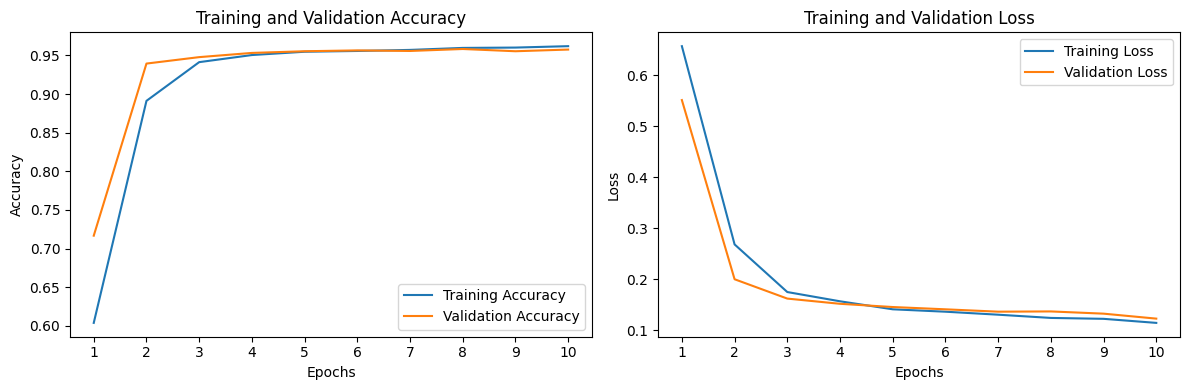

In [11]:
# Now, you can call these functions separately after evaluating the model
plot_accuracy_loss(history)
print_last_epoch_metrics(history)


- Training Accuracy: 0.9619 
- Validation Accuracy: 0.9575 
- Training Loss: 0.1149 
- Validation Loss: 0.1232
87/87 [==============================] - 14s 164ms/step


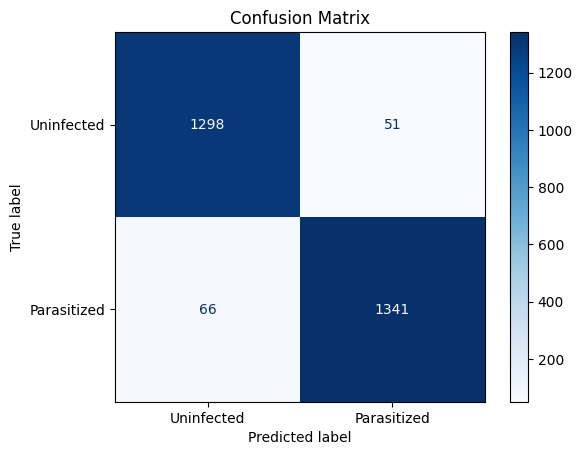

In [12]:
# Displaying the confusion matrix
display_confusion_matrix(model, X_test, y_test)

1/1 [==============================] - 0s 44ms/step


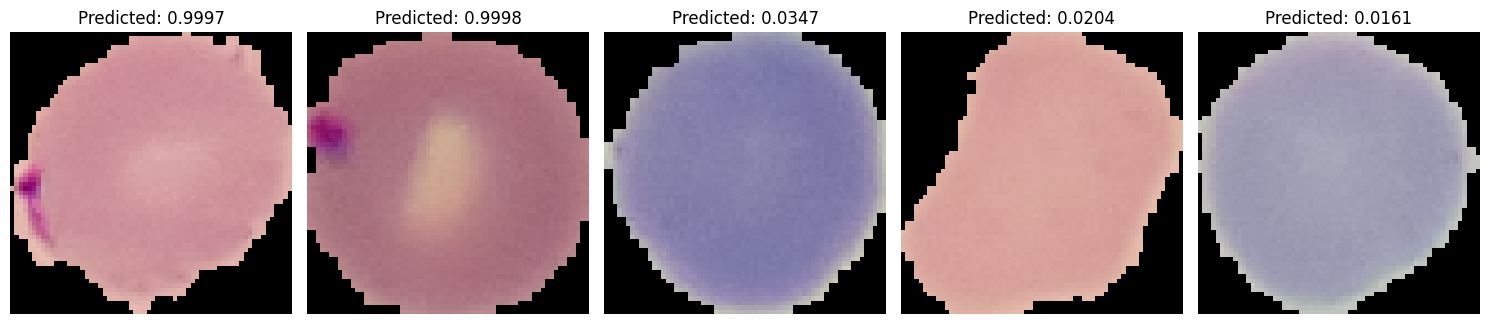

In [13]:
# Displaying sample images
sample_images = X_test[:5]
display_sample_images(model, sample_images)